In [225]:
#Packages##
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import scipy, pylab
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pandas import Series, DataFrame
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
%matplotlib inline
import seaborn; seaborn.set()

In [226]:
##Read Data##
virus_19 = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-03-22.csv', header=0)
virus_19.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,3/22/20,22,3,2020,0,0,Afghanistan,AF
1,3/21/20,21,3,2020,2,0,Afghanistan,AF
2,3/20/20,20,3,2020,0,0,Afghanistan,AF
3,3/19/20,19,3,2020,0,0,Afghanistan,AF
4,3/18/20,18,3,2020,1,0,Afghanistan,AF


In [227]:
virus_19 = virus_19.drop(["Day", "Month", "Year"], axis=1)
virus_19.head()

,DateRep,Cases,Deaths,Countries and territories,GeoId
0,3/22/20,0,0,Afghanistan,AF
1,3/21/20,2,0,Afghanistan,AF
2,3/20/20,0,0,Afghanistan,AF
3,3/19/20,0,0,Afghanistan,AF
4,3/18/20,1,0,Afghanistan,AF


In [228]:
virus_19 = virus_19.rename(columns={"Countries and territories": "Countries"})
virus_19.head()

,DateRep,Cases,Deaths,Countries,GeoId
0,3/22/20,0,0,Afghanistan,AF
1,3/21/20,2,0,Afghanistan,AF
2,3/20/20,0,0,Afghanistan,AF
3,3/19/20,0,0,Afghanistan,AF
4,3/18/20,1,0,Afghanistan,AF


In [229]:
##Italy
Italy_virus_19=virus_19.query('Countries=="Italy"')
Italy_virus_19

,DateRep,Cases,Deaths,Countries,GeoId
3009,3/22/20,6557,795,Italy,IT
3010,3/21/20,5986,625,Italy,IT
3011,3/20/20,5322,429,Italy,IT
3012,3/19/20,4207,473,Italy,IT
3013,3/18/20,3526,347,Italy,IT
...,...,...,...,...,...
3087,1/4/20,0,0,Italy,IT
3088,1/3/20,0,0,Italy,IT
3089,1/2/20,0,0,Italy,IT
3090,1/1/20,0,0,Italy,IT


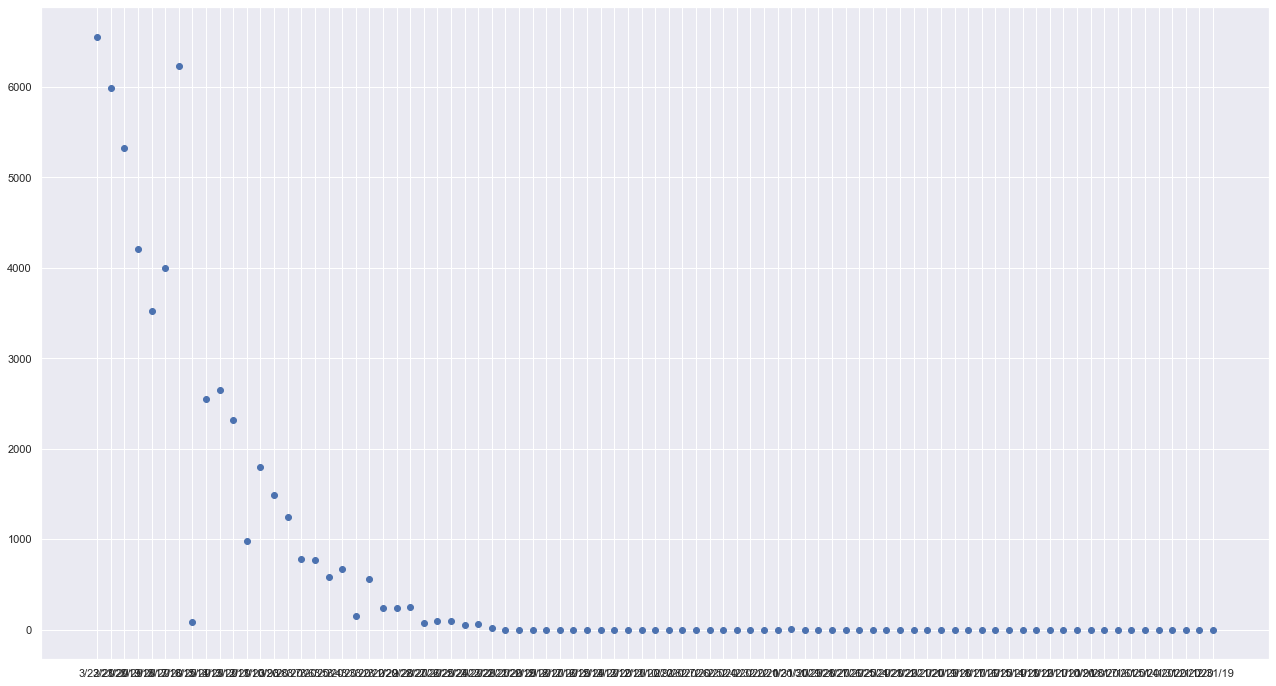

In [230]:
#Exploring Data##
fig, axes = plt.subplots(figsize=(22,12))
x = Italy_virus_19['DateRep']
y = Italy_virus_19['Cases']
plt.scatter(x,y)
plt.show()

In [231]:
virus_total=pd.pivot_table(data=Italy_virus_19, index='Countries', values=('Cases', 'Deaths'), aggfunc='sum')
virus_total

,Cases,Deaths
Countries,,
Italy,53578,4827


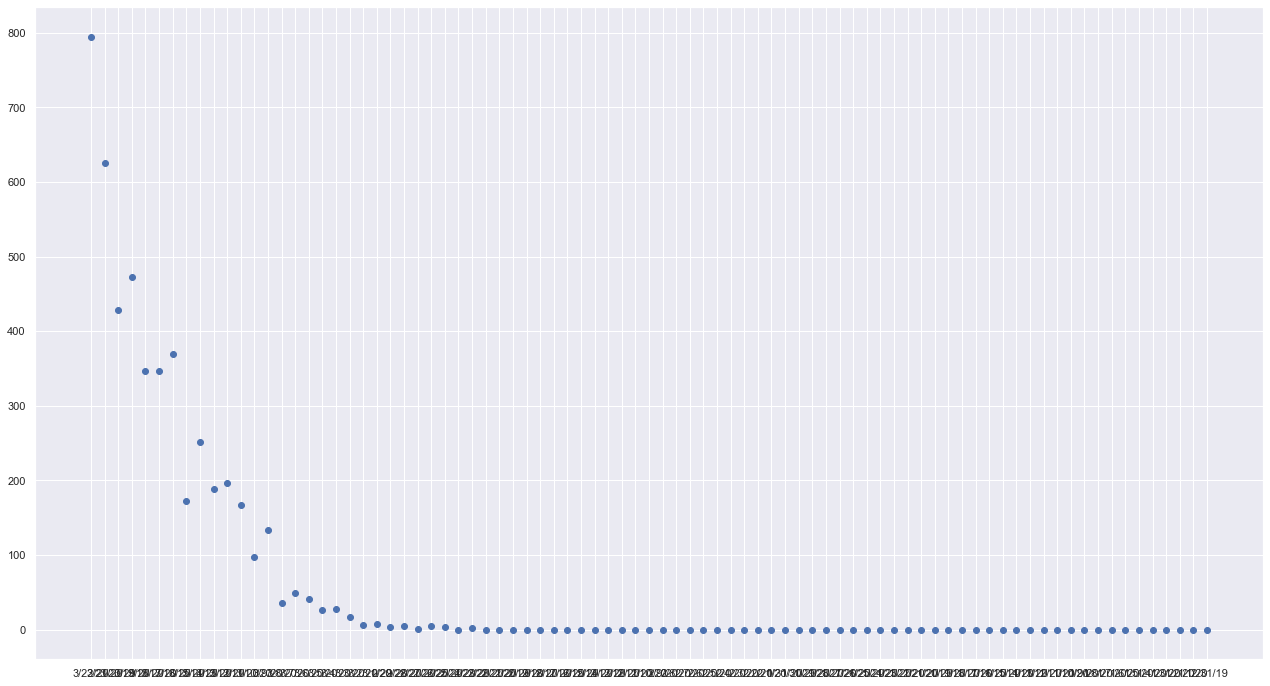

In [232]:
#Exploring Data##
fig, axes = plt.subplots(figsize=(22,12))
x = Italy_virus_19['DateRep']
y = Italy_virus_19['Deaths']
plt.scatter(x,y)
plt.show()

In [233]:
##*****TIme Series***##
# Validate Nule Data#
Italy_virus_19.loc[Italy_virus_19['Cases'].isnull()]
# Review odd data : 
Italy_virus_19[Italy_virus_19['Cases'].isin([np.nan, np.inf, -np.inf])]
Italy_virus_19[Italy_virus_19['Deaths'].isin([np.nan, np.inf, -np.inf])]
# To convert Date to datetime :
Italy_virus_19['DateRep'] = Italy_virus_19['DateRep'].astype('datetime64[ns]')
# Replace Nan Data
Italy_virus_19['Cases'] = Italy_virus_19['Cases'].fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [234]:
Italy_virus_19.index = Italy_virus_19.DateRep
Italy_virus_19 = Italy_virus_19.resample('D').mean()

In [235]:
# esto funcionará para rangos de fecha:
Italy_virus_19['2019-12-31':'2020-03-15']
# esto funcionará ver datos en un año dado:
Italy_virus_19['2020']

,Cases,Deaths
DateRep,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0
...,...,...
2020-03-18,3526,347
2020-03-19,4207,473
2020-03-20,5322,429


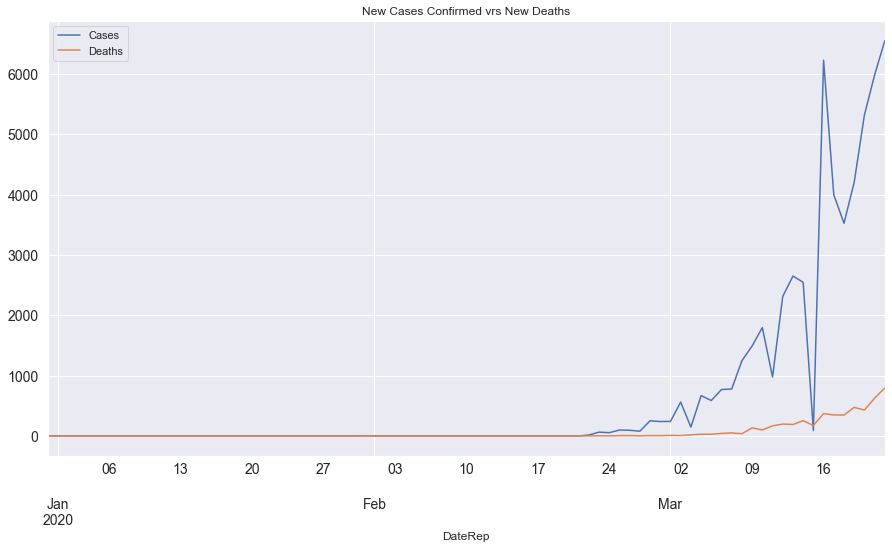

In [236]:
Italy_virus_19.plot(figsize=(15,8), title= 'New Cases Confirmed vrs New Deaths', fontsize=14)
plt.show()

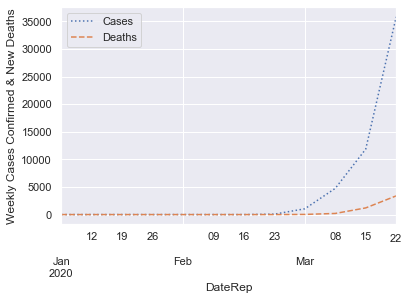

In [237]:
###Resample
weekly = Italy_virus_19.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly Cases Confirmed & New Deaths');

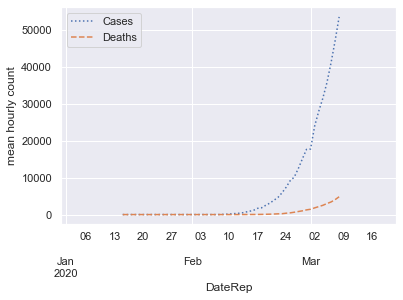

In [238]:
daily = Italy_virus_19.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

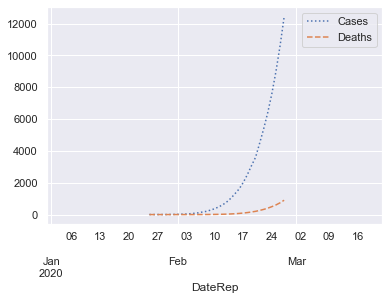

In [239]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

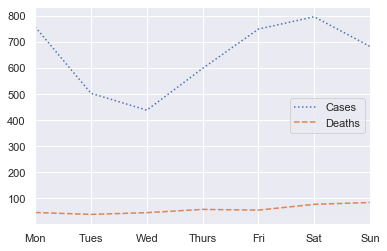

In [240]:
by_weekday = Italy_virus_19.groupby(Italy_virus_19.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

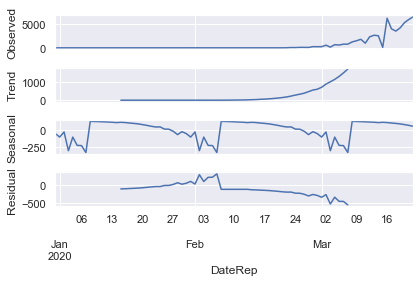

In [241]:
# Ejemplo de descomposición de serie de tiempo
descomposicion = sm.tsa.seasonal_decompose(Italy_virus_19['Cases'],
model='additive', freq=30)  
fig = descomposicion.plot()

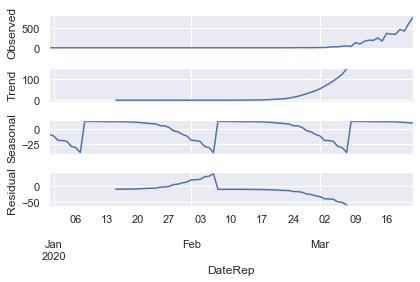

In [242]:
# Ejemplo de descomposición de serie de tiempo
descomposicion = sm.tsa.seasonal_decompose(Italy_virus_19['Deaths'],
model='additive', freq=30)  
fig = descomposicion.plot()

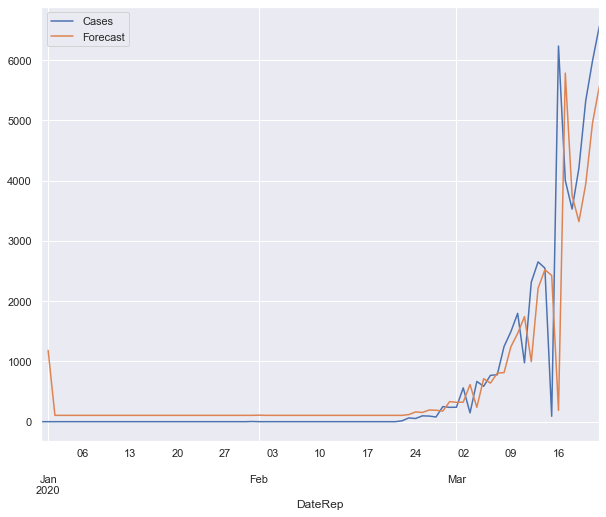

In [243]:
## Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(Italy_virus_19['Cases'].iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
Italy_virus_19['Forecast'] = resultados.fittedvalues  
plot = Italy_virus_19[['Cases', 'Forecast']].plot(figsize=(10, 8)) 

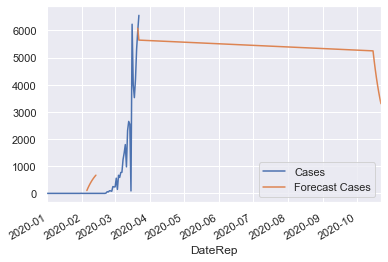

In [249]:
future=Italy_virus_19
future=future.reset_index()
mon=future["DateRep"]
mon=mon+pd.DateOffset(months=7)
future_dates = mon[-7-1:]
future = future.set_index('DateRep')
newDf = pd.DataFrame(index=future_dates, columns=future.columns)
future = pd.concat([future,newDf])
future["Forecast Cases"]= resultados.predict(start=35, end =43, dynamic=True)
future["Forecast Cases"].iloc[-10:]=resultados.forecast(steps=10)[0]
future[['Cases','Forecast Cases']].plot()

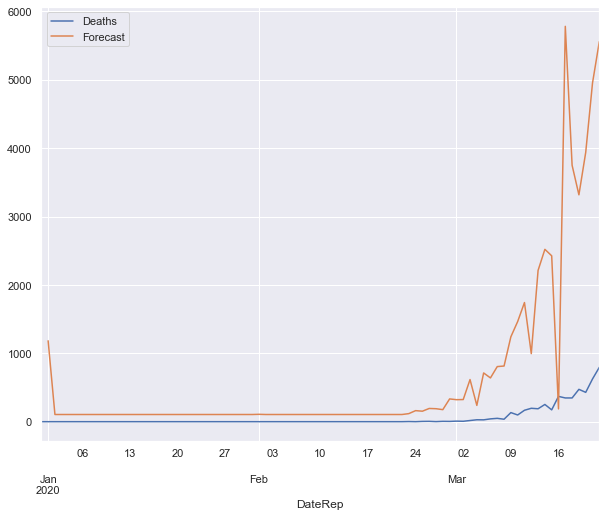

In [250]:
## Modelo ARIMA sobre el valor de cierre de la acción.
modelo_2 = sm.tsa.ARIMA(Italy_virus_19['Deaths'].iloc[1:], order=(1, 0, 0))  
resultados_2 = modelo_2.fit(disp=-1)  
Italy_virus_19['Forecast'] = resultados.fittedvalues  
plot = Italy_virus_19[['Deaths', 'Forecast']].plot(figsize=(10, 8)) 

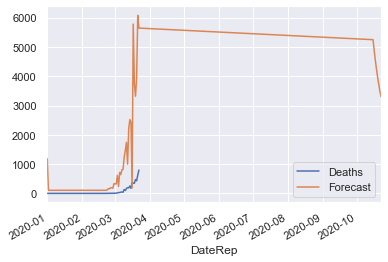

In [251]:
future_2=Italy_virus_19
future_2=future_2.reset_index()
mon=future_2["DateRep"]
mon=mon+pd.DateOffset(months=7)
future_dates_2 = mon[-7-1:]
future_2 = future_2.set_index('DateRep')
newDf_2 = pd.DataFrame(index=future_dates_2, columns=future_2.columns)
future_2 = pd.concat([future_2,newDf_2])
future_2["Forecast"]= resultados.predict(start=35, end =43, dynamic=True)
future["Forecast"].iloc[-10:]=resultados.forecast(steps=10)[0]
future[['Deaths','Forecast']].plot()

In [252]:
# calculando el porcentaje de variación del día.
Daily_var = Italy_virus_19['Cases'] / Italy_virus_19['Cases'].shift(1) - 1
Italy_virus_19['daily_var'] = Daily_var
Italy_virus_19['daily_var'][:5]

DateRep
2019-12-31   NaN
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
Freq: D, Name: daily_var, dtype: float64

In [253]:
# mismo resultado utilizando pct_change()
Italy_virus_19['Cases'].pct_change()[:5]

DateRep
2019-12-31   NaN
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
Freq: D, Name: Cases, dtype: float64

In [254]:
# calculando rendimiento acumulado diario
daily_inc = (1 + Italy_virus_19['Cases'].pct_change()).cumprod()
Italy_virus_19['inc_daily'] = daily_inc
Italy_virus_19['inc_daily'][:5]

DateRep
2019-12-31   NaN
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
Freq: D, Name: inc_daily, dtype: float64

In [255]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
Italy_virus_19_ciclo, Italy_virus_19_tend = sm.tsa.filters.hpfilter(Italy_virus_19['Cases'])
Italy_virus_19['tend'] = Italy_virus_19_tend

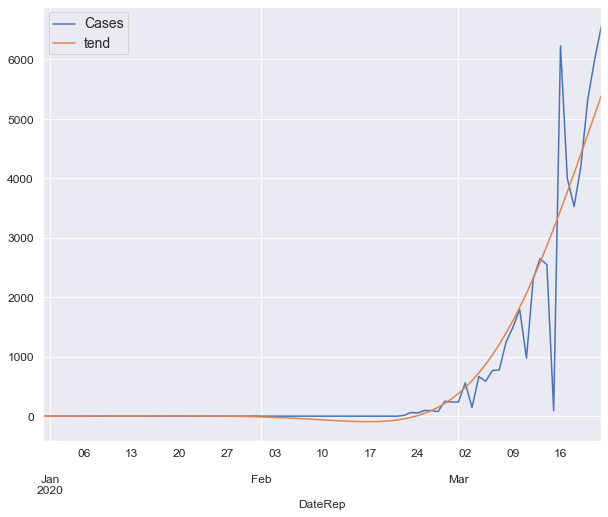

In [256]:
# graficando la variacion del precio real con la tendencia.
Italy_virus_19[['Cases', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

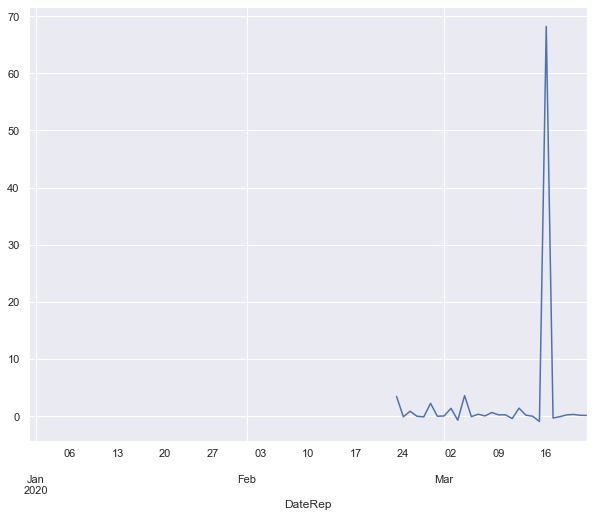

In [257]:
# graficando rendimiento diario
plot = Italy_virus_19['daily_var'].plot(figsize=(10, 8))